### Installing the relevant dependencies

In [ ]:
%%capture
!pip install lancedb scikit-learn openai torch sentence_transformers tiktoken umap-learn PyPDF2 tantivy

In [ ]:
import os
import uuid
import tiktoken
import re
import numpy as np
import pandas as pd
import transformers
import torch
import umap.umap_ as umap
import matplotlib.pyplot as plt
from openai import OpenAI
from typing import List, Tuple, Optional, Dict
from sklearn.mixture import GaussianMixture
from sentence_transformers import SentenceTransformer

openai_api_key = "******"
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
client = OpenAI(api_key=openai_api_key)
SEED = 1234

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
directory_path = '/content/data'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created successfully.")
else:
    print(f"Directory '{directory_path}' already exists.")

Directory '/content/data' already exists.


**Note:** Ensure that the `/content/data` folder (or the directory you choose) contains the relevant PDF files before running the script.

### Breaking down the data into chunks

In [ ]:
import os
import PyPDF2

# Function to extract text from a PDF file
def extract_pdf_text(file_path):
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page_num in range(len(reader.pages)):
            page = reader.pages[page_num]
            text += page.extract_text()
    return text

# Function to split text into chunks with overlap
def split_text(text, chunk_size=1000, chunk_overlap=50):
    chunks = []
    start = 0
    while start < len(text):
        end = min(start + chunk_size, len(text))
        chunks.append(text[start:end])
        start += chunk_size - chunk_overlap
    return chunks

# Function to process all PDFs in a directory
def process_directory(directory_path, chunk_size=1000, chunk_overlap=50):
    all_chunks = []
    # Iterate over all PDF files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".pdf"):
            file_path = os.path.join(directory_path, filename)
            print(f"Processing file: {file_path}")

            # Step 1: Extract text from the PDF
            pdf_text = extract_pdf_text(file_path)

            # Step 2: Split the extracted text into chunks
            chunks = split_text(pdf_text, chunk_size=chunk_size, chunk_overlap=chunk_overlap)

            # Append chunks from this file to the overall list
            all_chunks.extend(chunks)

    return all_chunks

chunk_size = 1000
chunk_overlap = 50

# Process all PDF files in the directory and get the chunks
chunks = process_directory(directory_path, chunk_size=chunk_size, chunk_overlap=chunk_overlap)

# Optional: Print the number of chunks and preview some of the chunks
print(f"Total number of chunks: {len(chunks)}")
for i, chunk in enumerate(chunks[:5]):  # Show first 5 chunks as a preview
    print(f"Chunk {i+1}:\n{chunk}\n")

Processing file: /content/data/report.pdf
Total number of chunks: 17
Chunk 1:
Note;ThisdocumentisinEnglishtranslationof“KessanTanshin”fortheThirdQuarteroftheFiscalYearEndingMarch31,2022andisprovidedsolelyforreferencepurposes.IntheeventofanyinconsistencybetweentheJapaneseversionandanyEnglishtranslationofit,theJapaneseversionwillgovern.ConsolidatedFinancialResultsfortheThirdQuarteroftheFiscalYearEndingMarch31,2022[IFRS]February4,2022Companyname:NTTDATACORPORATION(“NTTDATA”)StockexchangethatliststheCompany’sshares:TokyoStockExchange1stSectionCodenumber:9613URL:https://www.nttdata.com/global/en/Representative:YoHonma,PresidentandChiefExecutiveOfficerContact:SotaEndo,SeniorExecutiveManager,InvestorRelationsOfficeTel.:+81-3-5546-8119ScheduleddateoffilingofQuarterlyBusinessReport:February8,2022Scheduleddateofdividendpayment:-Supplementalmaterialonquarterlyresults:YesPresentationonquarterlyresults:Yes(forinstitutionalinvestorsandfinancialanalysts)(Amountsareroundedtothenearest1millionyen)1.Con

#### Dimensionality Reduction

When diving into RAPTOR, one of the biggest hurdles we encounter is the high dimensionality of vector embeddings. Traditional clustering methods like Gaussian Mixture Models (GMM) often struggle with this complexity, making it tough to effectively cluster high-dimensional data chunks. To tackle this challenge, we turn to Uniform Manifold Approximation and Projection (UMAP). UMAP excels at simplifying data while preserving the essential structures that matter most.


TLDR;

1. **Dimensionality Reduction** helps manage high-dimensional data, and UMAP is our primary tool for that.
2. The **`n_neighbors`** parameter controls the balance between seeing the "big picture" and honing in on local details.
3. The clustering process begins with **global clusters** (using high `n_neighbors`), followed by a focus on **local clusters** with a lower setting of `n_neighbors`.

In [ ]:
def dimensionality_reduction(
    embeddings: np.ndarray,
    target_dim: int,
    clustering_type: str,
    metric: str = "cosine",
) -> np.ndarray:
    if clustering_type == "local":
        n_neighbors = max(2, min(10, len(embeddings) - 1))
        min_dist = 0.01
    elif clustering_type == "global":
        n_neighbors = max(2, min(int((len(embeddings) - 1) ** 0.5), len(embeddings) // 10, len(embeddings) - 1))
        min_dist = 0.1
    else:
        raise ValueError("clustering_type must be either 'local' or 'global'")

    umap_model = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=target_dim,
        metric=metric,
    )
    return umap_model.fit_transform(embeddings)

### Optimal Number of Clusters



I plan to leverage both the Elbow Method and the Bayesian Information Criterion (BIC) to pinpoint the optimal number of clusters for our analysis.

In [ ]:
def compute_inertia(embeddings: np.ndarray, labels: np.ndarray, centroids: np.ndarray) -> float:
    return np.sum(np.min(np.sum((embeddings[:, np.newaxis] - centroids) ** 2, axis=2), axis=1))

def optimal_cluster_number(
    embeddings: np.ndarray,
    max_clusters: int = 50,
    random_state: int = SEED
) -> int:
    max_clusters = min(max_clusters, len(embeddings))
    number_of_clusters = np.arange(1, max_clusters + 1)
    inertias = []
    bic_scores = []

    for n in number_of_clusters:
        gmm = GaussianMixture(n_components=n, random_state=random_state)
        labels = gmm.fit_predict(embeddings)
        centroids = gmm.means_
        inertia = compute_inertia(embeddings, labels, centroids)
        inertias.append(inertia)
        bic_scores.append(gmm.bic(embeddings))

    inertia_changes = np.diff(inertias)
    elbow_optimal = number_of_clusters[np.argmin(inertia_changes) + 1]
    bic_optimal = number_of_clusters[np.argmin(bic_scores)]

    return max(elbow_optimal, bic_optimal)

def gmm_clustering(
    embeddings: np.ndarray,
    threshold: float,
    random_state: int = SEED
) -> Tuple[List[np.ndarray], int]:
    n_clusters = optimal_cluster_number(embeddings, random_state=random_state)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state, n_init=2)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

### Tree Construction

Now that we’ve wrapped up the clustering part, let’s talk about how we build our hierarchical tree. After several rounds of clustering and summarization (while keeping track of how deep we go), here’s what we have:

- **Leaf Nodes:** These are our original text chunks, forming the base of the tree.
- **Summary Nodes:** As we go up the tree, each node acts like a quick summary of its child nodes, capturing the main idea of the cluster.
- **Hierarchical Embeddings:** The summary nodes can also become the new nodes at their level. Each of these nodes gets its own vector embedding, representing the summarized meaning. So, we’re essentially adding more nodes while enriching them with summaries.

The process flows nicely: we embed the chunks, reduce their dimensions using UMAP, cluster them with Gaussian Mixture Models, start with a broad overview, and then zoom in for more detailed clusters before summarizing.

In [ ]:
def clustering_algorithm(
    embeddings: np.ndarray,
    target_dim: int,
    threshold: float,
    random_state: int = SEED
) -> Tuple[List[np.ndarray], int]:
    if len(embeddings) <= target_dim + 1:
        return [np.array([0]) for _ in range(len(embeddings))], 1

    # Global clustering
    reduced_global_embeddings = dimensionality_reduction(embeddings, target_dim, "global")
    global_clusters, n_global_clusters = gmm_clustering(reduced_global_embeddings, threshold, random_state=random_state)

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Local clustering within each global cluster
    for i in range(n_global_clusters):
        global_cluster_mask = np.array([i in gc for gc in global_clusters])
        global_cluster_embeddings = embeddings[global_cluster_mask]

        if len(global_cluster_embeddings) <= target_dim + 1:
            # Assign all points in this global cluster to a single local cluster
            for idx in np.where(global_cluster_mask)[0]:
                all_local_clusters[idx] = np.append(all_local_clusters[idx], total_clusters)
            total_clusters += 1
            continue

        try:
            reduced_local_embeddings = dimensionality_reduction(global_cluster_embeddings, target_dim, "local")
            local_clusters, n_local_clusters = gmm_clustering(reduced_local_embeddings, threshold, random_state=random_state)

            # Assign local cluster IDs
            for j in range(n_local_clusters):
                local_cluster_mask = np.array([j in lc for lc in local_clusters])
                global_indices = np.where(global_cluster_mask)[0]
                local_indices = global_indices[local_cluster_mask]
                for idx in local_indices:
                    all_local_clusters[idx] = np.append(all_local_clusters[idx], j + total_clusters)

            total_clusters += n_local_clusters
        except Exception as e:
            print(f"Error in local clustering for global cluster {i}: {str(e)}")
            # Assign all points in this global cluster to a single local cluster
            for idx in np.where(global_cluster_mask)[0]:
                all_local_clusters[idx] = np.append(all_local_clusters[idx], total_clusters)
            total_clusters += 1

    return all_local_clusters, total_clusters

def generate_summary(context: str) -> str:
    prompt = f"""
    Provide the Summary for the given context. Here are some additional instructions for you:

    Instructions:
    1. Don't make things up, Just use the contexts and generate the relevant summary.
    2. Don't mix the numbers, Just use the numbers in the context.
    3. Don't try to use fancy words, stick to the basics of the language that is being used in the context.

    Context: {context}
    """
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that summarizes text."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=200,
        n=1,
        stop=None,
        temperature=0.7
    )
    summary = response.choices[0].message.content.strip()
    return summary

def embed_clusters(
    texts: List[str],
    target_dim: int = 10,
    threshold: float = 0.1
) -> pd.DataFrame:
    textual_embeddings = np.array(embedding_model.encode(texts))
    clusters, number_of_clusters = clustering_algorithm(textual_embeddings, target_dim, threshold)
    print(f"Number of clusters: {number_of_clusters}")
    return pd.DataFrame({
        "texts": texts,
        "embedding": list(textual_embeddings),
        "clusters": clusters
    })

def embed_cluster_summaries(
    texts: List[str],
    level: int,
    target_dim: int = 10,
    threshold: float = 0.1
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df_clusters = embed_clusters(texts, target_dim, threshold)
    main_list = []

    for _, row in df_clusters.iterrows():
        for cluster in row["clusters"]:
            main_list.append({
                "text": row["texts"],
                "embedding": row["embedding"],
                "clusters": cluster
            })

    main_df = pd.DataFrame(main_list)
    unique_clusters = main_df["clusters"].unique()
    if len(unique_clusters) == 0:
        return df_clusters, pd.DataFrame(columns=["summaries", "level", "clusters"])

    print(f"--Generated {len(unique_clusters)} clusters--")

    summaries = []
    for cluster in unique_clusters:
        text_in_df = main_df[main_df["clusters"] == cluster]
        unique_texts = text_in_df["text"].tolist()
        text = "------\n------".join(unique_texts)
        summary = generate_summary(text)
        summaries.append(summary)

    df_summaries = pd.DataFrame({
        "summaries": summaries,
        "level": [level] * len(summaries),
        "clusters": unique_clusters
    })

    return df_clusters, df_summaries


def recursive_embedding_with_cluster_summarization(
    texts: List[str],
    number_of_levels: int = 3,
    level: int = 1,
    target_dim: int = 10,
    threshold: float = 0.1
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    if level > number_of_levels:
        return {}

    results = {}
    df_clusters, df_summaries = embed_cluster_summaries(texts, level, target_dim, threshold)
    results[level] = (df_clusters, df_summaries)

    if df_summaries.empty or len(df_summaries['clusters'].unique()) == 1:
        print(f"No more unique clusters found at level {level}. Stopping recursion.")
        return results

    if level < number_of_levels:
        next_level_texts = df_summaries['summaries'].tolist()
        next_level_results = recursive_embedding_with_cluster_summarization(
            next_level_texts,
            number_of_levels,
            level + 1,
            target_dim,
            threshold
        )
        results.update(next_level_results)

    return results


In [ ]:
def process_text_hierarchy(
    texts: List[str],
    number_of_levels: int = 3,
    target_dim: int = 10,
    threshold: float = 0.1
) -> Dict[str, pd.DataFrame]:
    hierarchy_results = recursive_embedding_with_cluster_summarization(
        texts, number_of_levels, target_dim=target_dim, threshold=threshold
    )

    processed_results = {}
    for level, (df_clusters, df_summaries) in hierarchy_results.items():
        if df_clusters.empty or df_summaries.empty:
            print(f"No data for level {level}. Skipping.")
            continue
        processed_results[f"level_{level}_clusters"] = df_clusters
        processed_results[f"level_{level}_summaries"] = df_summaries

    return processed_results


results = process_text_hierarchy(chunks, number_of_levels=3)

Number of clusters: 4
--Generated 4 clusters--
Number of clusters: 1
--Generated 1 clusters--
No more unique clusters found at level 2. Stopping recursion.


### RAG Formation

Now it’s smooth sailing! We’ll set up a LanceDB vector database to store our embeddings and facilitate querying our RAG setup. To compare the relevant results from both RAPTOR RAG and VANILLA RAG, I’ll configure both RAG systems.

In [ ]:
raptor_texts = []
for level, row in results.items():
    if level.endswith("clusters"):
        raptor_texts.extend(row["texts"])
    else:
        raptor_texts.extend(row["summaries"])

raptor_embeddings = embedding_model.encode(raptor_texts) # new raptor embeddings
normal_embeddings = embedding_model.encode(chunks) # default chunks from our data
print(raptor_embeddings)
print(normal_embeddings)

[[-0.02867434 -0.03404145  0.03183713 ... -0.11637738 -0.03496148
   0.02426555]
 [-0.02260254 -0.05349045  0.01649414 ... -0.07463644  0.06521226
   0.02849963]
 [-0.04479891 -0.05722785  0.07431144 ... -0.12457766 -0.07554325
   0.08023182]
 ...
 [-0.00617281 -0.02009849 -0.00419744 ... -0.09979296 -0.10421827
  -0.01685225]
 [-0.0961774  -0.01634985 -0.02820352 ... -0.08988537 -0.03870759
  -0.0209068 ]
 [-0.07575317 -0.00782455 -0.00337196 ... -0.11301762 -0.02062772
   0.02530929]]
[[-2.8674338e-02 -3.4041446e-02  3.1837128e-02 ... -1.1637738e-01
  -3.4961481e-02  2.4265550e-02]
 [-2.2602541e-02 -5.3490449e-02  1.6494140e-02 ... -7.4636437e-02
   6.5212265e-02  2.8499626e-02]
 [-4.4798914e-02 -5.7227850e-02  7.4311443e-02 ... -1.2457766e-01
  -7.5543255e-02  8.0231816e-02]
 ...
 [-6.6004984e-02 -7.7177368e-02  2.0053916e-02 ... -8.4871434e-02
   5.2336227e-02 -1.4862130e-06]
 [ 1.5349649e-02 -9.5823780e-02  1.1927984e-02 ... -8.5330136e-02
   6.6217750e-02  3.6647685e-02]
 [-8.265

With RAPTOR, we now have an increased number of chunks due to the addition of cluster-level summary nodes alongside the default chunks we had earlier.

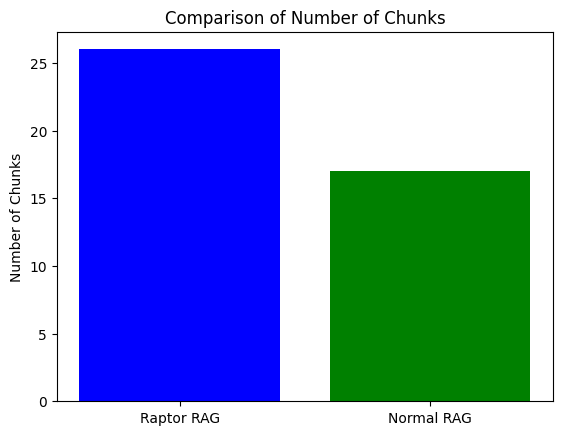

In [ ]:
# Compute lengths of the embeddings
raptor_length = len(raptor_embeddings)
normal_length = len(normal_embeddings)

# Bar graph data
labels = ['Raptor RAG', 'Normal RAG']
lengths = [raptor_length, normal_length]

# Create the bar graph
plt.bar(labels, lengths, color=['blue', 'green'])

# Add title and labels
plt.title('Comparison of Number of Chunks')
plt.ylabel('Number of Chunks')

# Show the plot
plt.show()

In [ ]:
raptor_dict = {"texts": [], "embeddings": []}
for texts, embeddings in zip(raptor_texts, raptor_embeddings):
    raptor_dict["texts"].append(texts)
    raptor_dict["embeddings"].append(embeddings.tolist())

normal_dict = {"texts": [], "embeddings": []}
for texts, embeddings in zip(chunks, normal_embeddings):
    normal_dict["texts"].append(texts)
    normal_dict["embeddings"].append(embeddings.tolist())

In [ ]:
rag_raptor_df = pd.DataFrame(raptor_dict)
print(rag_raptor_df.shape)

rag_normal_df = pd.DataFrame(normal_dict)
print(rag_normal_df.shape)

(26, 2)
(17, 2)


In [ ]:
import lancedb
import pyarrow as pa
from lancedb.pydantic import Vector, LanceModel

uri = "lancedb_database"
db = lancedb.connect(uri)

class RAG(LanceModel):
    texts : str
    embeddings : Vector(384)

table_name = "rag_with_raptor"
raptor_table = db.create_table(table_name, schema = RAG, mode="overwrite")
raptor_table.add(rag_raptor_df)
raptor_table.create_fts_index("texts", replace=True)

table_name = "rag_without_raptor"
normal_table = db.create_table(table_name, schema = RAG, mode="overwrite")
normal_table.add(rag_normal_df)
normal_table.create_fts_index("texts", replace=True)

In [ ]:
def generate_results(
    query : str,
    context_text : str
) -> str:

    prompt = f"""
    Based on the context provided, use it to answer the query.

    query : {query}

    Instructions:
    1. Don't make things up, Just use the contexts and generate the relevant answer.
    2. Don't mix the numbers, Just use the numbers in the context.
    3. Don't try to use fancy words, stick to the basics of the language that is being used in the context.

    {context_text}
    """
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that answers query and give the answers."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=200,
        n=1,
        stop=None,
        temperature=0.7
    )
    answer = response.choices[0].message.content.strip()
    return answer

In [ ]:
query = "NTT DATA's net income attributable to shareholders increased from ¥69,227 million in Q3 FY2020 to ¥110,191 million in Q3 FY2021. How does this growth align with their acquisition strategy, particularly considering their stated reasons for acquiring Nexient, LLC and the provisional goodwill recorded in this transaction?"
raptor_contexts = raptor_table.search(query).limit(5).select(["texts"]).to_list()
raptor_context_text = "------\n\n".join([context["texts"] for context in raptor_contexts])
raptor_context_text = "------\n\n" + raptor_context_text

normal_contexts = normal_table.search(query).limit(5).select(["texts"]).to_list()
normal_context_text = "------\n\n".join([context["texts"] for context in normal_contexts])
normal_context_text = "------\n\n" + normal_context_text

raptor_answer = generate_results(query, raptor_context_text)
normal_answer = generate_results(query, normal_context_text)

In [ ]:
raptor_answer

"The growth in NTT DATA's net income attributable to shareholders from ¥69,227 million in Q3 FY2020 to ¥110,191 million in Q3 FY2021 aligns with their acquisition strategy as it suggests a positive financial performance that can support such growth initiatives. The acquisition of Nexient, LLC, for instance, is expected to enhance NTT DATA's capabilities and better meet clients' needs, which could potentially lead to further growth in income. The cost of this acquisition was 286 million yen, indicating that the company is investing in strategic acquisitions to drive growth. The fact that no significant changes were made in subsidiaries, accounting policies, or accounting estimates, nor were there revisions to the forecasts of dividends and consolidated results, further indicates a stable financial condition that can support such growth-oriented strategies."

In [ ]:
normal_answer

"Based on the context provided, it can be seen that NTT DATA's net income attributable to shareholders has significantly increased from ¥69,227 million in Q3 FY2020 to ¥110,191 million in Q3 FY2021. However, the context does not provide information regarding how this growth aligns with their acquisition strategy. Similarly, there is no specific mention of their reasons for acquiring Nexient, LLC or the provisional goodwill recorded in this transaction. Therefore, it is not possible to provide a detailed answer to the query without making assumptions or adding additional information."